# Exploratory Data Analysis (EDA) for March Madness 2024

In this notebook, we load the raw competition data using our unified pre_processing module.  
We then preprocess seeds separately for men and women, inspect missing values, and visualize distributions, correlations,  
and sample feature constructions for both Logistic Regression and Random Forest.

# Step 1: Imports & Raw Data Loading

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust module path based on environment
if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('../../scripts')

# For EDA we want the separate (non-combined) datasets.
from pre_processing import build_model_pipeline

# Load raw data without combining (so that men and women remain separate)
data = build_model_pipeline(model_type='eda', combine=False)

# Print basic info and first 3 rows for each dataset
for gender, dictionary in data.items():
    for key, df in dictionary.items():
        print(f"{key}: {df.shape}")
        print(df.head(3))
        print("\n")

Teams: (378, 4)
   TeamID     TeamName  FirstD1Season  LastD1Season
0    1101  Abilene Chr           2014          2024
1    1102    Air Force           1985          2024
2    1103        Akron           1985          2024


Seasons: (40, 6)
   Season     DayZero RegionW    RegionX    RegionY    RegionZ
0    1985  10/29/1984    East       West    Midwest  Southeast
1    1986  10/28/1985    East    Midwest  Southeast       West
2    1987  10/27/1986    East  Southeast    Midwest       West


RegResults: (187289, 8)
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985      20     1228      81     1328      64    N      0
1    1985      25     1106      77     1354      70    H      0
2    1985      25     1112      63     1223      56    H      0


TourneyResults: (2451, 8)
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2  

# Step 2: Preprocess Seeds & Missing Value Inspection:

We preprocess seeds and check missing values in key datasets.

In [2]:
men_seeds = data["M"]["Seeds"]
women_seeds = data["W"]["Seeds"]

print("Men's Seeds after preprocessing:")
print(men_seeds.head(5))
print("\nWomen's Seeds after preprocessing:")
print(women_seeds.head(5))
print("\n")

for gender, datasets in data.items():
    print(f"--- {gender} ---")
    for name, df in datasets.items():
        print(f"Missing values in {name}:")
        print(df.isnull().sum())
        print("\n")

Men's Seeds after preprocessing:
   Season Seed  TeamID  SeedNum
0    1985  W01    1207        1
1    1985  W02    1210        2
2    1985  W03    1228        3
3    1985  W04    1260        4
4    1985  W05    1374        5

Women's Seeds after preprocessing:
   Season Seed  TeamID  SeedNum
0    1998  W01    3330        1
1    1998  W02    3163        2
2    1998  W03    3112        3
3    1998  W04    3301        4
4    1998  W05    3272        5


--- M ---
Missing values in Teams:
TeamID           0
TeamName         0
FirstD1Season    0
LastD1Season     0
dtype: int64


Missing values in Seasons:
Season     0
DayZero    0
RegionW    0
RegionX    0
RegionY    0
RegionZ    0
dtype: int64


Missing values in RegResults:
Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64


Missing values in TourneyResults:
Season     0
DayNum     0
WTeamID    0
WScore     0
LTeamID    0
LScore     0
WLoc       0
NumOT      0
dtype: int64

# Step 3: Logistic Regression–Specific Feature EDA

In this section, we simulate the LR pipeline: we build team stats and matchup features
for both men's and women's tournament data using the LR-specific functions.

Men's Team Season Statistics:
   Season  TeamID  Games  Wins  PointsFor  PointsAgainst  Losses    WinPct  \
0    1985    1102     24     5       1514           1653      19  0.208333   
1    1985    1103     23     9       1404           1474      14  0.391304   
2    1985    1104     30    21       2055           1821       9  0.700000   

   AvgMargin  
0  -5.791667  
1  -3.043478  
2   7.800000  

Summary Statistics for All Men's Teams:
WinPct Mean: 0.494 | Std: 0.189
AvgMargin Mean: -0.236 | Std: 6.808


Men's Tournament Teams - Summary:
WinPct Mean: 0.725 | Std: 0.099
AvgMargin Mean: 7.839 | Std: 4.353
WinPct Range: 0.357 to 1.000




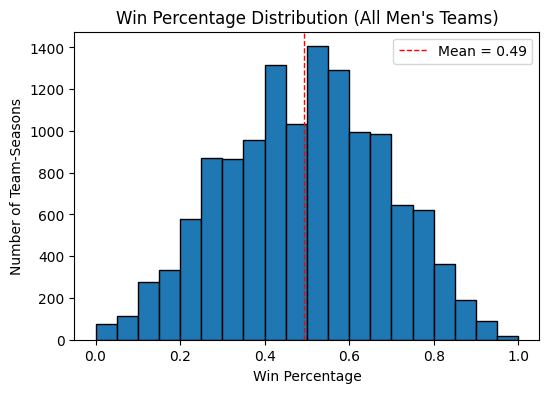

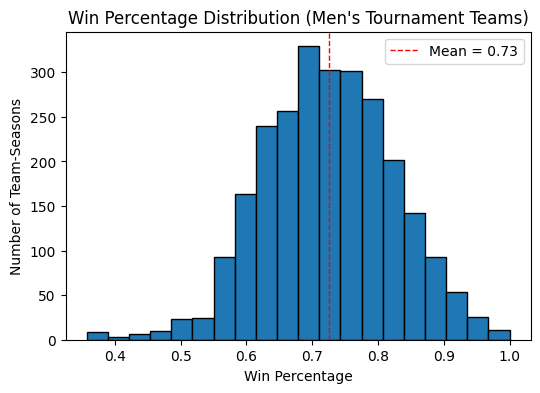

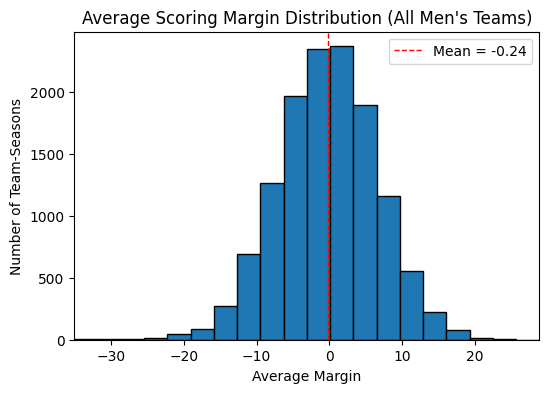

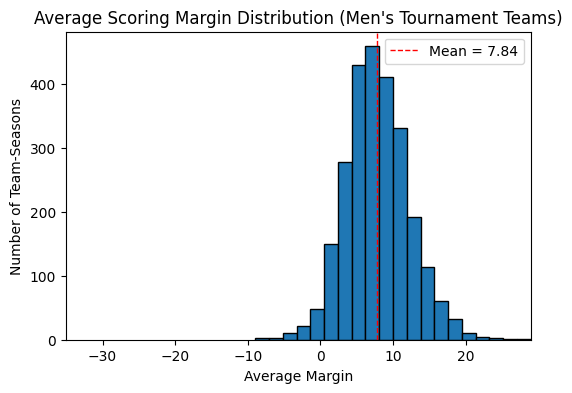

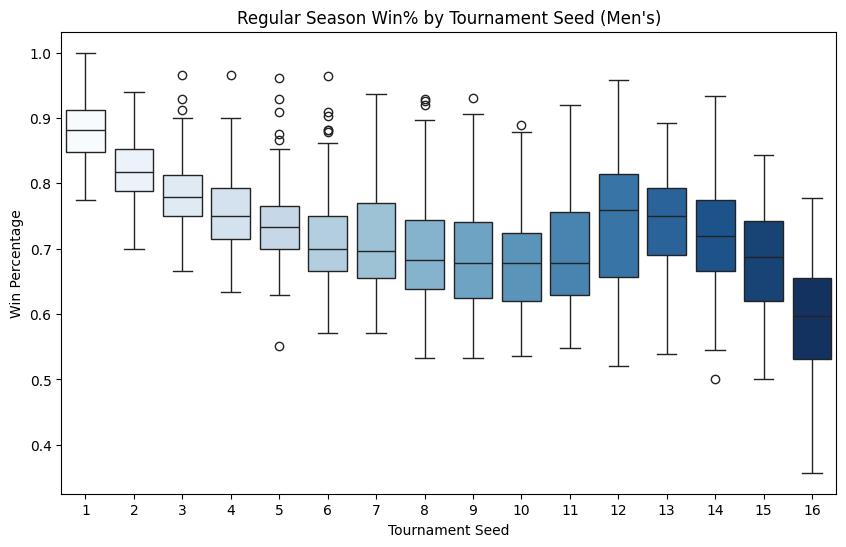

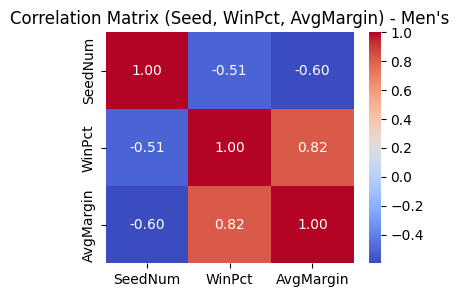

In [3]:
# -----------------------------
# Men's Data Analysis
# -----------------------------
# For LR, use the separate compact data stored in raw_data
m_reg = data["M"]["RegResults"]
m_tourney = data["M"]["TourneyResults"]

def build_team_stats_lr(reg_results):
    # Mimic original behavior using compute_team_stats on the compact data.
    games = []
    for _, row in reg_results.iterrows():
        season = row["Season"]
        games.append({
            "Season": season, 
            "TeamID": row["WTeamID"],
            "PointsFor": row["WScore"], 
            "PointsAgainst": row["LScore"], 
            "Win": 1
        })
        games.append({
            "Season": season, 
            "TeamID": row["LTeamID"],
            "PointsFor": row["LScore"], 
            "PointsAgainst": row["WScore"], 
            "Win": 0
        })
    df = pd.DataFrame(games)
    agg = df.groupby(["Season", "TeamID"]).agg(
        Games=("Win", "count"),
        Wins=("Win", "sum"),
        PointsFor=("PointsFor", "sum"),
        PointsAgainst=("PointsAgainst", "sum")
    ).reset_index()
    agg["Losses"] = agg["Games"] - agg["Wins"]
    agg["WinPct"] = agg["Wins"] / agg["Games"]
    agg["AvgMargin"] = (agg["PointsFor"] - agg["PointsAgainst"]) / agg["Games"]
    return agg

m_team_stats = build_team_stats_lr(m_reg)
print("Men's Team Season Statistics:")
print(m_team_stats.head(3))
print("\nSummary Statistics for All Men's Teams:")
print(f"WinPct Mean: {m_team_stats['WinPct'].mean():.3f} | Std: {m_team_stats['WinPct'].std():.3f}")
print(f"AvgMargin Mean: {m_team_stats['AvgMargin'].mean():.3f} | Std: {m_team_stats['AvgMargin'].std():.3f}")
print("\n")

# Merge seeds with team stats for tournament teams (Men's)
m_tourney_teams = pd.merge(men_seeds[['Season', 'TeamID', 'SeedNum']], m_team_stats, on=['Season', 'TeamID'])
print("Men's Tournament Teams - Summary:")
print(f"WinPct Mean: {m_tourney_teams['WinPct'].mean():.3f} | Std: {m_tourney_teams['WinPct'].std():.3f}")
print(f"AvgMargin Mean: {m_tourney_teams['AvgMargin'].mean():.3f} | Std: {m_tourney_teams['AvgMargin'].std():.3f}")
print(f"WinPct Range: {m_tourney_teams['WinPct'].min():.3f} to {m_tourney_teams['WinPct'].max():.3f}")
print("\n")

# Plot histogram for Win Percentage (All Men's Teams)
plt.figure(figsize=(6, 4))
plt.hist(m_team_stats['WinPct'], bins=20, edgecolor='black')
plt.title("Win Percentage Distribution (All Men's Teams)")
plt.xlabel("Win Percentage")
plt.ylabel("Number of Team-Seasons")
plt.axvline(m_team_stats['WinPct'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {m_team_stats['WinPct'].mean():.2f}")
plt.legend()
plt.show()

# Plot histogram for Win Percentage (Men's Tournament Teams)
plt.figure(figsize=(6, 4))
plt.hist(m_tourney_teams['WinPct'], bins=20, edgecolor='black')
plt.title("Win Percentage Distribution (Men's Tournament Teams)")
plt.xlabel("Win Percentage")
plt.ylabel("Number of Team-Seasons")
plt.axvline(m_tourney_teams['WinPct'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {m_tourney_teams['WinPct'].mean():.2f}")
plt.legend()
plt.show()

# Determine common x-axis range for AvgMargin (Men's)
x_min_m = min(m_team_stats['AvgMargin'].min(), m_tourney_teams['AvgMargin'].min())
x_max_m = max(m_team_stats['AvgMargin'].max(), m_tourney_teams['AvgMargin'].max())

# Histogram for Average Scoring Margin (All Men's Teams)
plt.figure(figsize=(6, 4))
plt.hist(m_team_stats['AvgMargin'], bins=20, edgecolor='black')
plt.title("Average Scoring Margin Distribution (All Men's Teams)")
plt.xlabel("Average Margin")
plt.ylabel("Number of Team-Seasons")
plt.axvline(m_team_stats['AvgMargin'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {m_team_stats['AvgMargin'].mean():.2f}")
plt.xlim(x_min_m, x_max_m)
plt.legend()
plt.show()

# Histogram for Average Scoring Margin (Men's Tournament Teams)
plt.figure(figsize=(6, 4))
plt.hist(m_tourney_teams['AvgMargin'], bins=20, edgecolor='black')
plt.title("Average Scoring Margin Distribution (Men's Tournament Teams)")
plt.xlabel("Average Margin")
plt.ylabel("Number of Team-Seasons")
plt.axvline(m_tourney_teams['AvgMargin'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {m_tourney_teams['AvgMargin'].mean():.2f}")
plt.xlim(x_min_m, x_max_m)
plt.legend()
plt.show()

# Boxplot: Regular Season Win% by Tournament Seed (Men's)
plt.figure(figsize=(10, 6))
sns.boxplot(x='SeedNum', y='WinPct', data=m_tourney_teams, hue='SeedNum', palette="Blues")
plt.title("Regular Season Win% by Tournament Seed (Men's)")
plt.xlabel("Tournament Seed")
plt.ylabel("Win Percentage")
plt.legend([],[], frameon=False)
plt.show()

# Correlation Matrix Heatmap (Seed, WinPct, AvgMargin) - Men's
m_corr = m_tourney_teams[['SeedNum', 'WinPct', 'AvgMargin']].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(m_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Seed, WinPct, AvgMargin) - Men's")
plt.show()

Women's Team Season Statistics:
   Season  TeamID  Games  Wins  PointsFor  PointsAgainst  Losses    WinPct  \
0    1998    3102     24     4       1375           1870      20  0.166667   
1    1998    3103     29    11       2008           2178      18  0.379310   
2    1998    3104     30    21       2297           1894       9  0.700000   

   AvgMargin  
0 -20.625000  
1  -5.862069  
2  13.433333  

Summary Statistics for All Women's Teams:
WinPct Mean: 0.494 | Std: 0.206
AvgMargin Mean: -0.267 | Std: 8.745


Women's Tournament Teams - Summary:
WinPct Mean: 0.750 | Std: 0.107
AvgMargin Mean: 10.646 | Std: 6.174
WinPct Range: 0.407 to 1.000




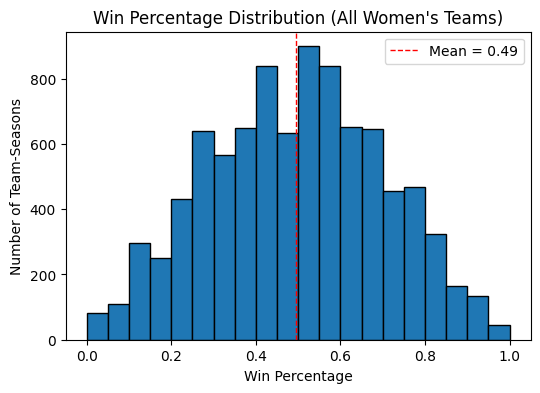

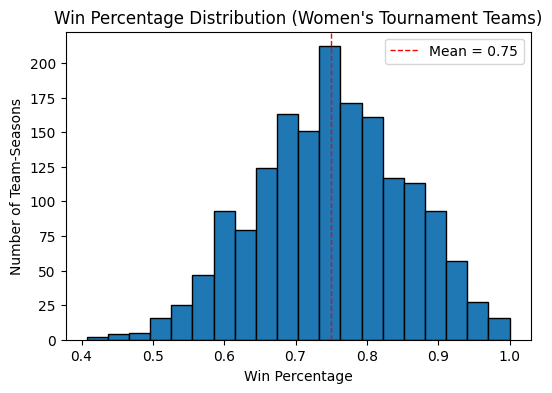

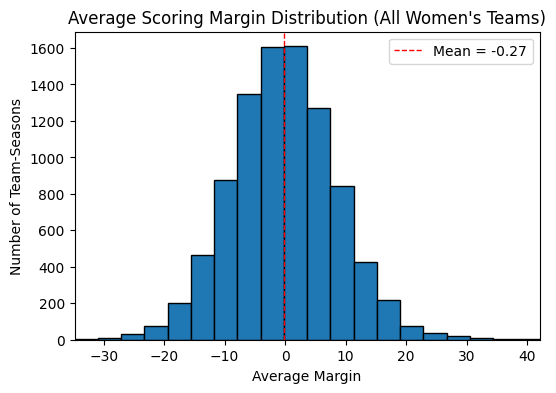

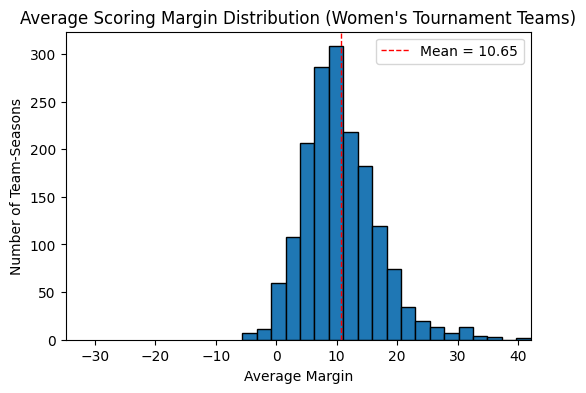

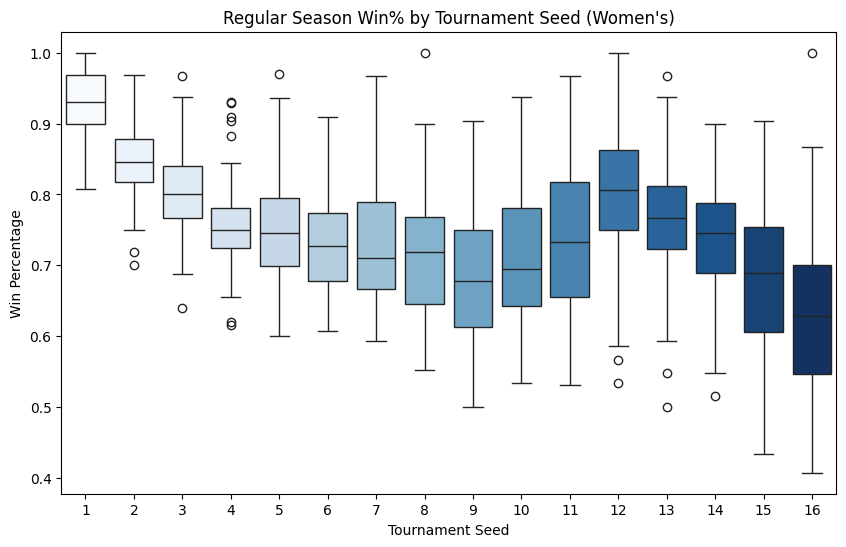

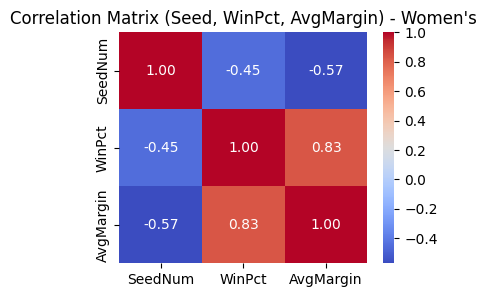

In [4]:
# -----------------------------
# Women's Data Analysis
# -----------------------------
w_reg = data["W"]["RegResults"]
w_tourney = data["W"]["TourneyResults"]

w_team_stats = build_team_stats_lr(w_reg)
print("Women's Team Season Statistics:")
print(w_team_stats.head(3))
print("\nSummary Statistics for All Women's Teams:")
print(f"WinPct Mean: {w_team_stats['WinPct'].mean():.3f} | Std: {w_team_stats['WinPct'].std():.3f}")
print(f"AvgMargin Mean: {w_team_stats['AvgMargin'].mean():.3f} | Std: {w_team_stats['AvgMargin'].std():.3f}")
print("\n")

# Merge seeds with team stats for tournament teams (Women's)
w_tourney_teams = pd.merge(women_seeds[['Season', 'TeamID', 'SeedNum']], w_team_stats, on=['Season', 'TeamID'])
print("Women's Tournament Teams - Summary:")
print(f"WinPct Mean: {w_tourney_teams['WinPct'].mean():.3f} | Std: {w_tourney_teams['WinPct'].std():.3f}")
print(f"AvgMargin Mean: {w_tourney_teams['AvgMargin'].mean():.3f} | Std: {w_tourney_teams['AvgMargin'].std():.3f}")
print(f"WinPct Range: {w_tourney_teams['WinPct'].min():.3f} to {w_tourney_teams['WinPct'].max():.3f}")
print("\n")

# Plot histogram for Win Percentage (All Women's Teams)
plt.figure(figsize=(6, 4))
plt.hist(w_team_stats['WinPct'], bins=20, edgecolor='black')
plt.title("Win Percentage Distribution (All Women's Teams)")
plt.xlabel("Win Percentage")
plt.ylabel("Number of Team-Seasons")
plt.axvline(w_team_stats['WinPct'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {w_team_stats['WinPct'].mean():.2f}")
plt.legend()
plt.show()

# Plot histogram for Win Percentage (Women's Tournament Teams)
plt.figure(figsize=(6, 4))
plt.hist(w_tourney_teams['WinPct'], bins=20, edgecolor='black')
plt.title("Win Percentage Distribution (Women's Tournament Teams)")
plt.xlabel("Win Percentage")
plt.ylabel("Number of Team-Seasons")
plt.axvline(w_tourney_teams['WinPct'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {w_tourney_teams['WinPct'].mean():.2f}")
plt.legend()
plt.show()

# Determine common x-axis range for AvgMargin (Women's)
x_min_w = min(w_team_stats['AvgMargin'].min(), w_tourney_teams['AvgMargin'].min())
x_max_w = max(w_team_stats['AvgMargin'].max(), w_tourney_teams['AvgMargin'].max())

# Histogram for Average Scoring Margin (All Women's Teams)
plt.figure(figsize=(6, 4))
plt.hist(w_team_stats['AvgMargin'], bins=20, edgecolor='black')
plt.title("Average Scoring Margin Distribution (All Women's Teams)")
plt.xlabel("Average Margin")
plt.ylabel("Number of Team-Seasons")
plt.axvline(w_team_stats['AvgMargin'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {w_team_stats['AvgMargin'].mean():.2f}")
plt.xlim(x_min_w, x_max_w)
plt.legend()
plt.show()

# Histogram for Average Scoring Margin (Women's Tournament Teams)
plt.figure(figsize=(6, 4))
plt.hist(w_tourney_teams['AvgMargin'], bins=20, edgecolor='black')
plt.title("Average Scoring Margin Distribution (Women's Tournament Teams)")
plt.xlabel("Average Margin")
plt.ylabel("Number of Team-Seasons")
plt.axvline(w_tourney_teams['AvgMargin'].mean(), color='red', linestyle='dashed', linewidth=1,
            label=f"Mean = {w_tourney_teams['AvgMargin'].mean():.2f}")
plt.xlim(x_min_w, x_max_w)
plt.legend()
plt.show()

# Boxplot: Regular Season Win% by Tournament Seed (Women's)
plt.figure(figsize=(10, 6))
sns.boxplot(x='SeedNum', y='WinPct', data=w_tourney_teams, hue='SeedNum', palette="Blues")
plt.title("Regular Season Win% by Tournament Seed (Women's)")
plt.xlabel("Tournament Seed")
plt.ylabel("Win Percentage")
plt.legend([],[], frameon=False)
plt.show()

# Correlation Matrix Heatmap (Seed, WinPct, AvgMargin) - Women's
w_corr = w_tourney_teams[['SeedNum', 'WinPct', 'AvgMargin']].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(w_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix (Seed, WinPct, AvgMargin) - Women's")
plt.show()

In [5]:
from pre_processing import build_model_pipeline
import pandas as pd

# Load men's and women's detailed results (not combined yet)
raw_detailed = build_model_pipeline(
    model_type="eda_detailed",
    combine=False
)

# Extract detailed tournament results
df_m = raw_detailed['M']['TourneyResults'].copy()
df_w = raw_detailed['W']['TourneyResults'].copy()

# Add gender column
df_m['Gender'] = 'M'
df_w['Gender'] = 'W'

# Combine into one DataFrame
df = pd.concat([df_m, df_w], ignore_index=True)

print(f"✅ Loaded detailed data: {len(df)} total games (Men: {len(df_m)}, Women: {len(df_w)})")
print(df[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'Gender']].head(3))


✅ Loaded detailed data: 2142 total games (Men: 1315, Women: 827)
   Season  DayNum  WTeamID  LTeamID Gender
0    2003     134     1421     1411      M
1    2003     136     1112     1436      M
2    2003     136     1113     1272      M


In [6]:
# Calculate engineered features
df['AstDiff'] = df['WAst'] - df['LAst']
df['TORDiff'] = df['WTO'] - df['LTO']
df['ScoreDiff'] = df['WScore'] - df['LScore']
df['AssistPerPoint'] = df['WAst'] / df['WScore']

# Quick display of sample rows
print("✅ Sample with new features:")
display(df[['Gender', 'AstDiff', 'TORDiff', 'ScoreDiff', 'AssistPerPoint']].head())

✅ Sample with new features:


,Gender,AstDiff,TORDiff,ScoreDiff,AssistPerPoint
0,M,1,-3,8,0.184783
1,M,10,-1,29,0.275000
2,M,7,-3,13,0.214286
3,M,-5,-3,6,0.189873
4,M,1,-1,2,0.223684


In [7]:
# Define threshold for AstDiff being "significant"
assist_threshold = 7

# Compare average score diff with and without assist advantage
high_ast = df[df['AstDiff'] >= assist_threshold]
low_ast = df[df['AstDiff'] < assist_threshold]

avg_high = high_ast['ScoreDiff'].mean()
avg_low = low_ast['ScoreDiff'].mean()

print(f"📊 Avg ScoreDiff with AstDiff >= {assist_threshold}: {avg_high:.2f}")
print(f"📉 Avg ScoreDiff with AstDiff < {assist_threshold}: {avg_low:.2f}")

if avg_high > avg_low + 3:
    print("✅ GOOD CHECK: High assist difference correlates with better win margins.")
else:
    print("⚠️ WEAK CHECK: No strong correlation found.")


📊 Avg ScoreDiff with AstDiff >= 7: 22.40
📉 Avg ScoreDiff with AstDiff < 7: 10.31
✅ GOOD CHECK: High assist difference correlates with better win margins.


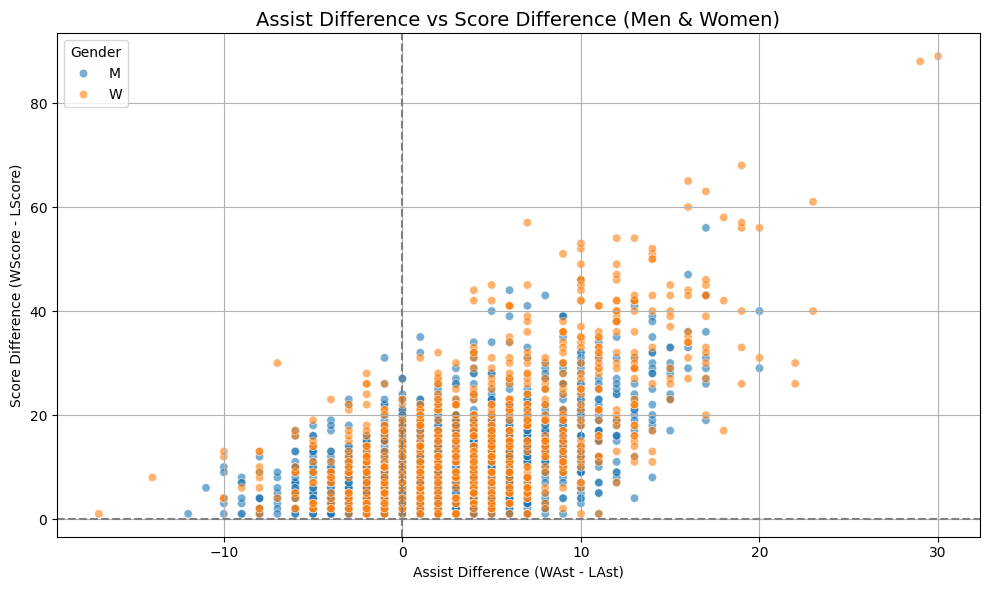

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================
# 🔹 BLOCK 4: Scatterplot – Assist Diff vs Score Diff
# ==============================================

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='AstDiff', y='ScoreDiff', hue='Gender', alpha=0.6)
plt.title("Assist Difference vs Score Difference (Men & Women)", fontsize=14)
plt.xlabel("Assist Difference (WAst - LAst)")
plt.ylabel("Score Difference (WScore - LScore)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Turnover Difference by Gender (WTO - LTO):
            mean       std
Gender                    
M      -0.713308  4.833839
W      -1.279323  5.874441

✅ % of games where winners had fewer turnovers:
Men: 51.56% of games
Women: 56.23% of games


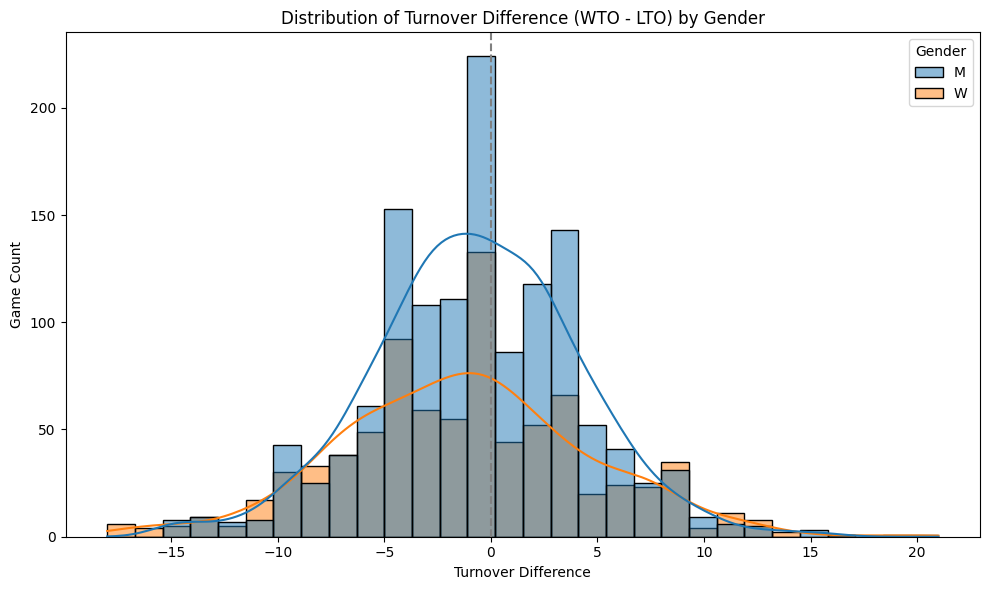

In [9]:
# 1. Look at mean TORDiff by gender
tor_summary = df.groupby('Gender')['TORDiff'].agg(['mean', 'std'])
print("📊 Turnover Difference by Gender (WTO - LTO):")
print(tor_summary)

# 2. Check percentage of games where winning team had fewer turnovers (TORDiff < 0)
def calc_tor_advantage_ratio(sub_df):
    total = len(sub_df)
    adv = (sub_df['TORDiff'] < 0).sum()
    return round(adv / total * 100, 2)

men_ratio = calc_tor_advantage_ratio(df[df['Gender'] == 'M'])
women_ratio = calc_tor_advantage_ratio(df[df['Gender'] == 'W'])

print(f"\n✅ % of games where winners had fewer turnovers:")
print(f"Men: {men_ratio}% of games")
print(f"Women: {women_ratio}% of games")

# Optional: print distribution plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TORDiff', hue='Gender', bins=30, kde=True)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Distribution of Turnover Difference (WTO - LTO) by Gender")
plt.xlabel("Turnover Difference")
plt.ylabel("Game Count")
plt.tight_layout()
plt.show()


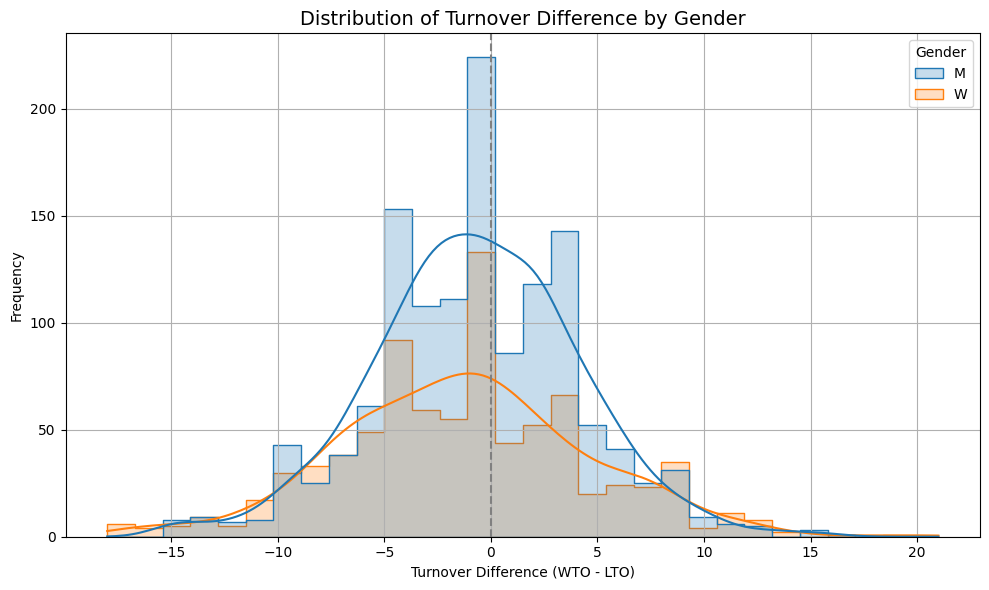

In [10]:
# ==============================================
# 🔹 BLOCK 5: Histogram – Turnover Difference by Gender
# ==============================================

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TORDiff', hue='Gender', bins=30, kde=True, element='step')
plt.title("Distribution of Turnover Difference by Gender", fontsize=14)
plt.xlabel("Turnover Difference (WTO - LTO)")
plt.ylabel("Frequency")
plt.axvline(0, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


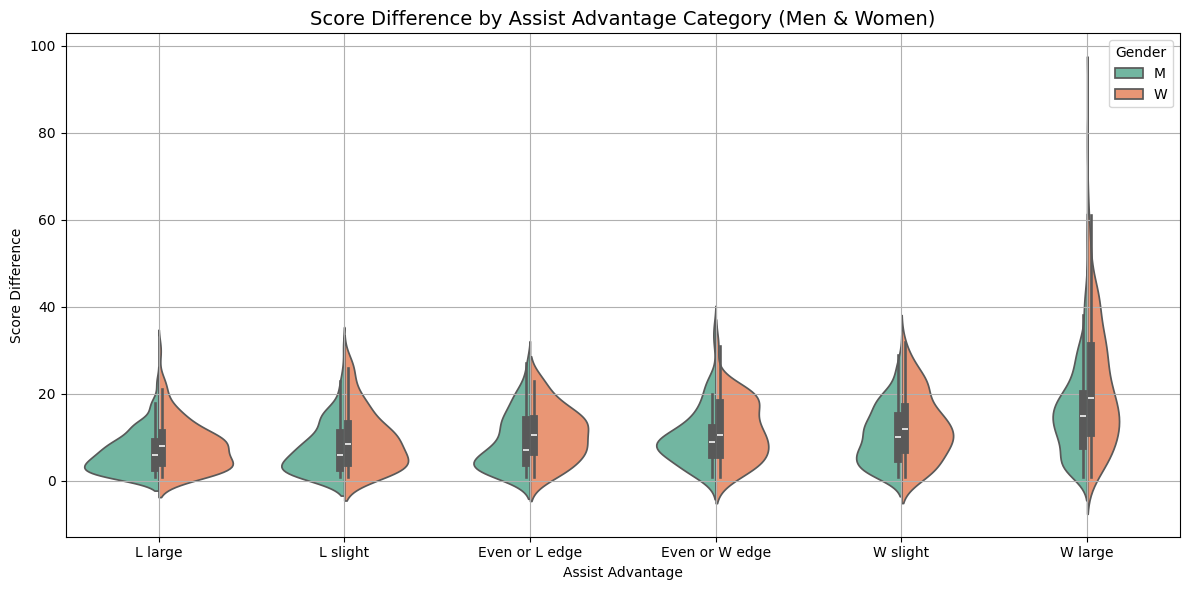

In [11]:
# ==============================================
# 🔹 BLOCK 6: Violinplot – ScoreDiff by AssistAdvantage
# ==============================================

# Create categorical advantage label
df['AssistAdvantage'] = pd.cut(
    df['AstDiff'],
    bins=[-float('inf'), -3, -1, 0, 1, 3, float('inf')],
    labels=['L large', 'L slight', 'Even or L edge', 'Even or W edge', 'W slight', 'W large']
)

plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='AssistAdvantage', y='ScoreDiff', hue='Gender', palette='Set2', split=True)
plt.title("Score Difference by Assist Advantage Category (Men & Women)", fontsize=14)
plt.xlabel("Assist Advantage")
plt.ylabel("Score Difference")
plt.grid(True)
plt.tight_layout()
plt.show()


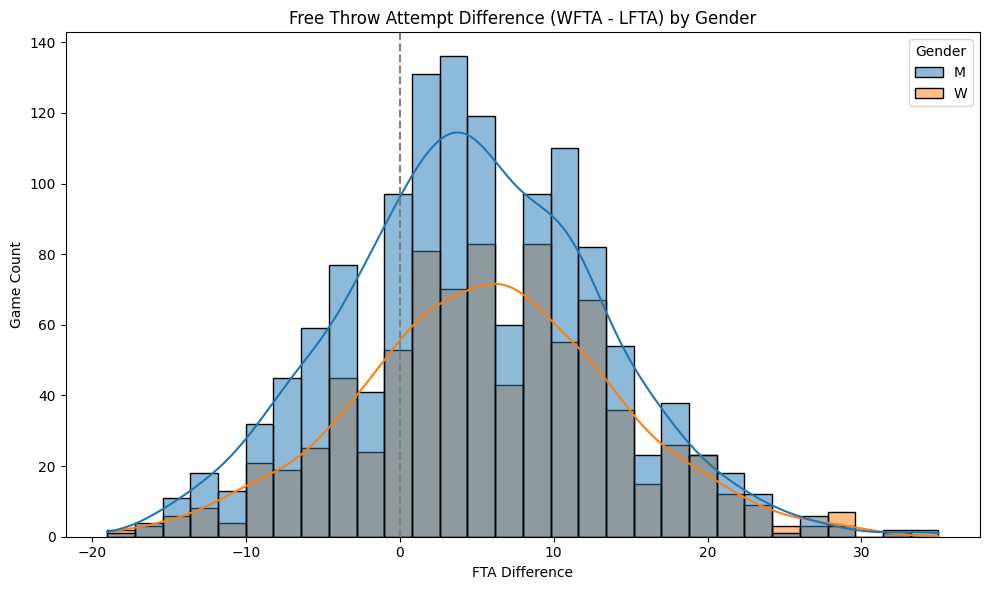

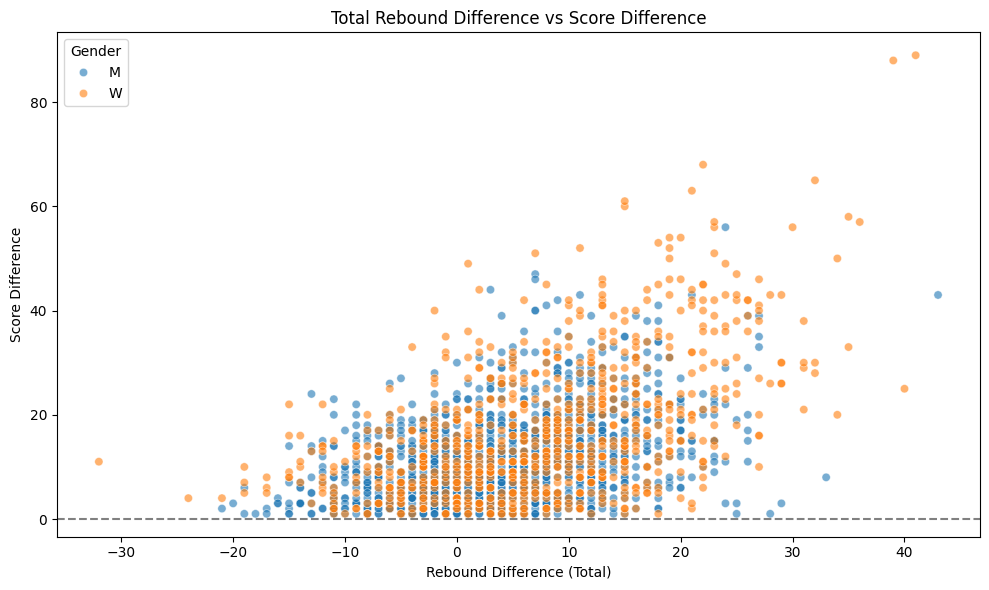

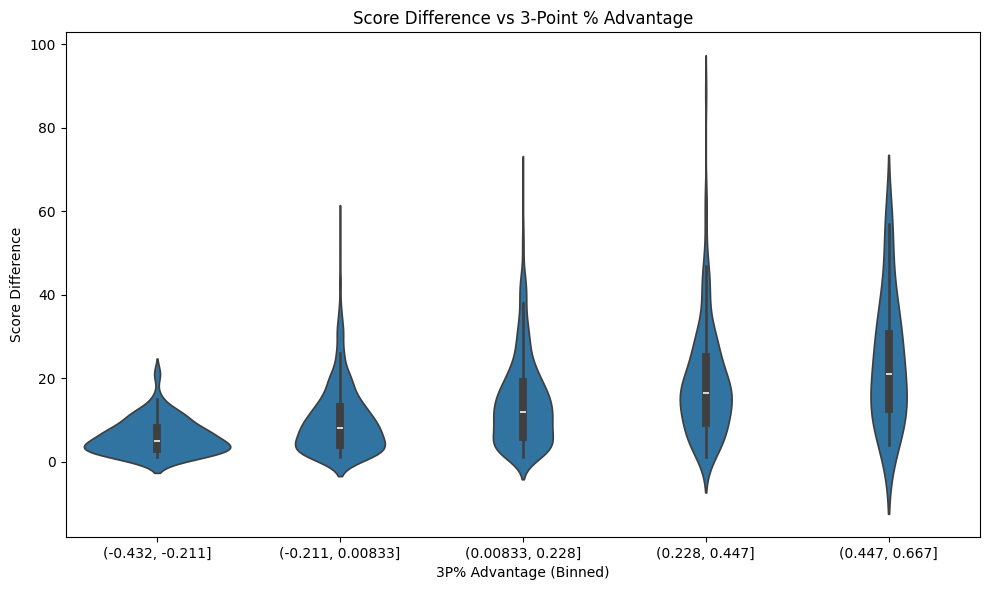

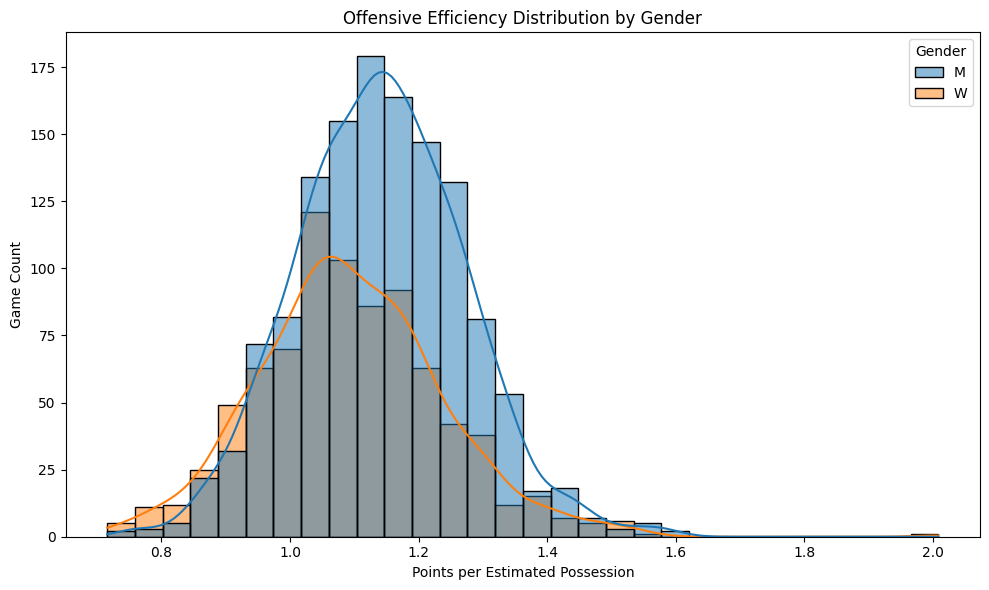

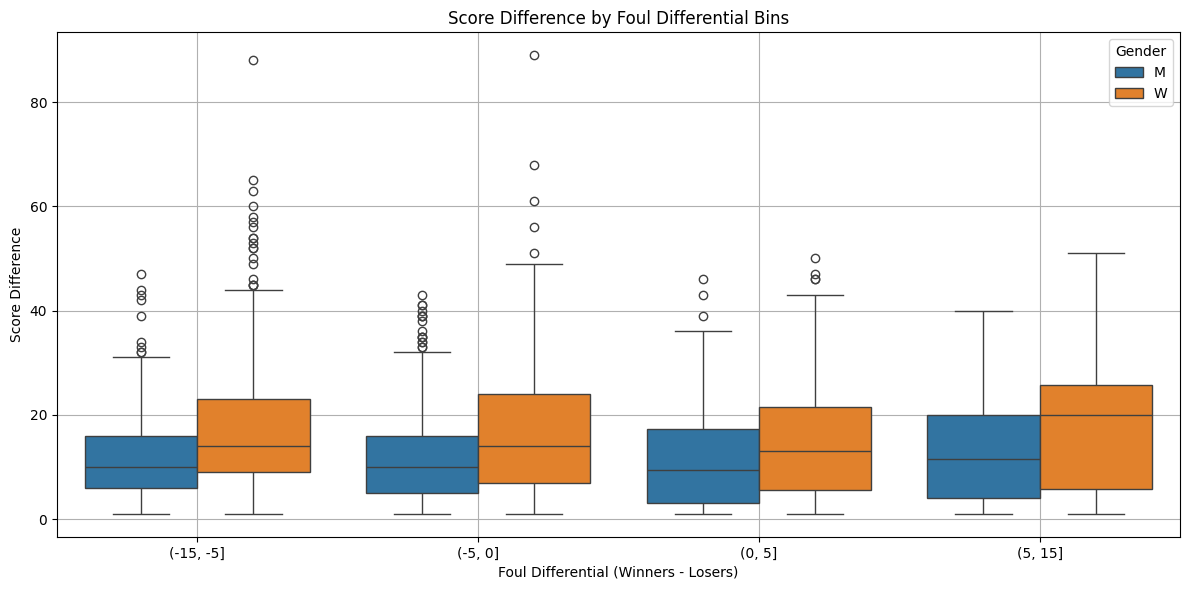

In [12]:
# FULL WORKING BLOCK – EDA RESEARCH FEATURES & VISUALIZATION

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Adjust module path
if os.path.exists('/kaggle/input'):
    sys.path.append('/kaggle/input/preprocessing-module')
else:
    sys.path.append('/mnt/data')

# Import preprocessing logic
from pre_processing import build_model_pipeline

# 🔹 Load detailed results for both men and women (combined)
data = build_model_pipeline(model_type="eda_detailed", combine=False)
df_m = data['M']['TourneyResults'].copy()
df_w = data['W']['TourneyResults'].copy()

df_m['Gender'] = 'M'
df_w['Gender'] = 'W'
df = pd.concat([df_m, df_w], ignore_index=True)

# ======================================================
# 📌 1 – Free Throw Advantage
# ======================================================
df['FTADiff'] = df['WFTA'] - df['LFTA']

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='FTADiff', hue='Gender', bins=30, kde=True)
plt.title("Free Throw Attempt Difference (WFTA - LFTA) by Gender")
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("FTA Difference")
plt.ylabel("Game Count")
plt.tight_layout()
plt.show()

# ======================================================
# 📌 2 – Rebound Differential
# ======================================================
df['RebDiff'] = (df['WOR'] + df['WDR']) - (df['LOR'] + df['LDR'])
df['ScoreDiff'] = df['WScore'] - df['LScore']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='RebDiff', y='ScoreDiff', hue='Gender', alpha=0.6)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Total Rebound Difference vs Score Difference")
plt.xlabel("Rebound Difference (Total)")
plt.ylabel("Score Difference")
plt.tight_layout()
plt.show()

# ======================================================
# 📌 3 – 3-Point Efficiency Difference
# ======================================================
df['W3Pct'] = df['WFGM3'] / df['WFGA3'].replace(0, 1)
df['L3Pct'] = df['LFGM3'] / df['LFGA3'].replace(0, 1)
df['ThreePtDiff'] = df['W3Pct'] - df['L3Pct']

plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x=pd.cut(df['ThreePtDiff'], bins=5), y='ScoreDiff')
plt.title("Score Difference vs 3-Point % Advantage")
plt.xlabel("3P% Advantage (Binned)")
plt.ylabel("Score Difference")
plt.tight_layout()
plt.show()

# ======================================================
# 📌 4 – Offensive Efficiency Proxy
# ======================================================
df['Possessions'] = (df['WFGA'] - df['WOR'] + df['WTO'] + 0.44 * df['WFTA']).replace(0, 1)
df['OffEff'] = df['WScore'] / df['Possessions']

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='OffEff', hue='Gender', bins=30, kde=True)
plt.title("Offensive Efficiency Distribution by Gender")
plt.xlabel("Points per Estimated Possession")
plt.ylabel("Game Count")
plt.tight_layout()
plt.show()

# ======================================================
# 📌 5 – Foul Difference vs ScoreDiff
# ======================================================
df['FoulDiff'] = df['WPF'] - df['LPF']

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x=pd.cut(df['FoulDiff'], bins=[-15, -5, 0, 5, 15]), y='ScoreDiff', hue='Gender')
plt.title("Score Difference by Foul Differential Bins")
plt.xlabel("Foul Differential (Winners - Losers)")
plt.ylabel("Score Difference")
plt.grid(True)
plt.tight_layout()
plt.show()
